## Setup

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Initialize issues tracker
issues = []

print("✅ Libraries loaded successfully")
print(f"Validation started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries loaded successfully
Validation started at: 2025-12-27 21:00:20


In [2]:
# Connect to database
conn = sqlite3.connect('../tennis_data.db')

# Load all data
players_df = pd.read_sql_query("SELECT * FROM players", conn)
matches_df = pd.read_sql_query("SELECT * FROM matches", conn)
stats_df = pd.read_sql_query("SELECT * FROM statistics", conn)

matches_df['tournament_date'] = pd.to_datetime(matches_df['tournament_date'])

print(f"📊 Data Loaded:")
print(f"   Players: {len(players_df):,}")
print(f"   Matches: {len(matches_df):,}")
print(f"   Statistics Records: {len(stats_df):,}")

📊 Data Loaded:
   Players: 780
   Matches: 13,166
   Statistics Records: 25,242


## 1. Completeness Checks

In [3]:
print("="*80)
print("1. COMPLETENESS CHECKS")
print("="*80)

# Total matches
total_matches = len(matches_df)
print(f"\n📈 Total matches in database: {total_matches:,}")

# Matches with statistics
matches_with_stats = stats_df['match_id'].nunique()
stats_coverage = (matches_with_stats / total_matches) * 100
print(f"✅ Matches with complete statistics: {matches_with_stats:,} ({stats_coverage:.1f}%)")

if stats_coverage < 90:
    issues.append({
        'check': 'Completeness',
        'issue': f'Statistics coverage below 90%: {stats_coverage:.1f}%',
        'severity': 'WARNING',
        'count': total_matches - matches_with_stats
    })

# Statistics with actual data (not null)
stats_with_aces = stats_df[stats_df['aces'].notna()]
aces_coverage = (len(stats_with_aces) / len(stats_df)) * 100
print(f"✅ Statistics records with aces data: {len(stats_with_aces):,} ({aces_coverage:.1f}%)")

# Matches without betting odds (note: Tennis Abstract doesn't include odds)
print(f"\n⚠️  Betting odds: NOT AVAILABLE in Tennis Abstract dataset")
print(f"   (Tennis Abstract focuses on match statistics, not betting markets)")

# Players with few matches
player_match_counts = pd.concat([
    matches_df['winner_id'].value_counts(),
    matches_df['loser_id'].value_counts()
]).groupby(level=0).sum()

players_few_matches = (player_match_counts < 10).sum()
print(f"\n👤 Players with <10 matches: {players_few_matches} ({players_few_matches/len(players_df)*100:.1f}%)")

if players_few_matches / len(players_df) > 0.3:
    issues.append({
        'check': 'Completeness',
        'issue': f'{players_few_matches} players have fewer than 10 matches',
        'severity': 'INFO',
        'count': players_few_matches
    })

# Missing values by column
print(f"\n📋 Missing Values Analysis:")
print(f"\nMatches Table:")
matches_missing = matches_df.isnull().sum()
matches_missing_pct = (matches_missing / len(matches_df)) * 100
missing_summary = pd.DataFrame({
    'Missing': matches_missing,
    'Percentage': matches_missing_pct
})
print(missing_summary[missing_summary['Missing'] > 0].sort_values('Missing', ascending=False))

print(f"\nStatistics Table:")
stats_missing = stats_df.isnull().sum()
stats_missing_pct = (stats_missing / len(stats_df)) * 100
stats_missing_summary = pd.DataFrame({
    'Missing': stats_missing,
    'Percentage': stats_missing_pct
})
print(stats_missing_summary[stats_missing_summary['Missing'] > 0].sort_values('Missing', ascending=False))

1. COMPLETENESS CHECKS

📈 Total matches in database: 13,166
✅ Matches with complete statistics: 12,621 (95.9%)
✅ Statistics records with aces data: 25,242 (100.0%)

⚠️  Betting odds: NOT AVAILABLE in Tennis Abstract dataset
   (Tennis Abstract focuses on match statistics, not betting markets)

👤 Players with <10 matches: 500 (64.1%)

📋 Missing Values Analysis:

Matches Table:
                    Missing  Percentage
loser_seed             9917   75.322801
winner_seed            7660   58.180161
minutes                 872    6.623120
loser_rank              150    1.139298
loser_rank_points       150    1.139298
winner_rank              62    0.470910
winner_rank_points       62    0.470910
surface                  53    0.402552
loser_age                 3    0.022786
winner_age                2    0.015191

Statistics Table:
                      Missing  Percentage
validation_flags        25242  100.000000
break_point_save_pct     1234    4.888678
second_serve_win_pct        4    0.0

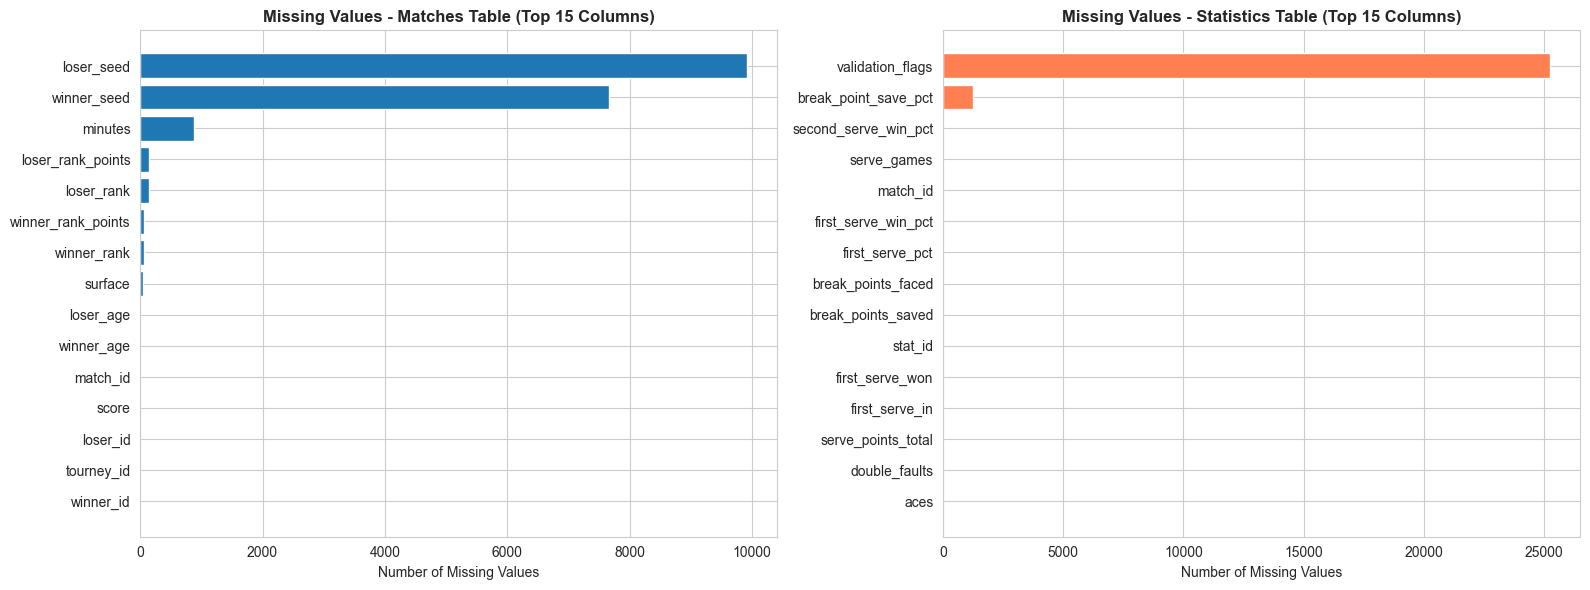

✅ Missing values heatmap saved: missing_values_heatmap.png


In [4]:
# Missing values heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matches missing data
matches_missing_matrix = matches_df.isnull().sum().sort_values(ascending=False)[:15]
axes[0].barh(range(len(matches_missing_matrix)), matches_missing_matrix.values)
axes[0].set_yticks(range(len(matches_missing_matrix)))
axes[0].set_yticklabels(matches_missing_matrix.index)
axes[0].set_xlabel('Number of Missing Values')
axes[0].set_title('Missing Values - Matches Table (Top 15 Columns)', fontweight='bold')
axes[0].invert_yaxis()

# Statistics missing data
stats_missing_matrix = stats_df.isnull().sum().sort_values(ascending=False)[:15]
axes[1].barh(range(len(stats_missing_matrix)), stats_missing_matrix.values, color='coral')
axes[1].set_yticks(range(len(stats_missing_matrix)))
axes[1].set_yticklabels(stats_missing_matrix.index)
axes[1].set_xlabel('Number of Missing Values')
axes[1].set_title('Missing Values - Statistics Table (Top 15 Columns)', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('missing_values_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Missing values heatmap saved: missing_values_heatmap.png")

## 2. Data Range Validation

In [5]:
print("="*80)
print("2. DATA RANGE VALIDATION")
print("="*80)

# Check percentages are in [0, 1]
percentage_cols = ['first_serve_pct', 'first_serve_win_pct', 'second_serve_win_pct', 'break_point_save_pct']
invalid_percentages = 0

for col in percentage_cols:
    if col in stats_df.columns:
        invalid = stats_df[(stats_df[col] < 0) | (stats_df[col] > 1)][col].dropna()
        if len(invalid) > 0:
            invalid_percentages += len(invalid)
            print(f"⚠️  {col}: {len(invalid)} values outside [0, 1]")
            issues.append({
                'check': 'Range Validation',
                'issue': f'{col} has {len(invalid)} values outside [0, 1]',
                'severity': 'ERROR',
                'count': len(invalid)
            })

if invalid_percentages == 0:
    print("✅ All percentage values are within [0, 1]")

# Check aces (should be reasonable, < 30 per match is normal, >30 is suspicious)
high_aces = stats_df[stats_df['aces'] > 30]
if len(high_aces) > 0:
    print(f"\n⚠️  Suspicious ace counts (>30): {len(high_aces)} records")
    print(f"   Max aces in a match: {stats_df['aces'].max():.0f}")
    issues.append({
        'check': 'Range Validation',
        'issue': f'{len(high_aces)} matches with >30 aces (suspicious)',
        'severity': 'WARNING',
        'count': len(high_aces)
    })
else:
    print(f"\n✅ All ace counts are reasonable (<30)")
    print(f"   Max aces in a match: {stats_df['aces'].max():.0f}")

# Check double faults (>15 is high but possible)
high_dfs = stats_df[stats_df['double_faults'] > 20]
if len(high_dfs) > 0:
    print(f"\n⚠️  High double fault counts (>20): {len(high_dfs)} records")
    print(f"   Max DFs in a match: {stats_df['double_faults'].max():.0f}")
else:
    print(f"\n✅ Double fault counts are reasonable")
    print(f"   Max DFs in a match: {stats_df['double_faults'].max():.0f}")

# Check dates are reasonable (2020-2024)
date_min = matches_df['tournament_date'].min()
date_max = matches_df['tournament_date'].max()
print(f"\n📅 Date Range: {date_min.strftime('%Y-%m-%d')} to {date_max.strftime('%Y-%m-%d')}")

if date_min.year < 2020 or date_max.year > 2025:
    issues.append({
        'check': 'Range Validation',
        'issue': f'Dates outside expected range: {date_min} to {date_max}',
        'severity': 'WARNING',
        'count': 0
    })

# Check rankings are reasonable (1-2000)
high_ranks = matches_df[(matches_df['winner_rank'] > 2000) | (matches_df['loser_rank'] > 2000)]
if len(high_ranks) > 0:
    print(f"\n⚠️  Rankings >2000: {len(high_ranks)} matches")
else:
    print(f"\n✅ All rankings are reasonable (≤2000)")

print(f"\n✅ Data range validation complete")

2. DATA RANGE VALIDATION
⚠️  second_serve_win_pct: 1 values outside [0, 1]

⚠️  Suspicious ace counts (>30): 68 records
   Max aces in a match: 54

⚠️  High double fault counts (>20): 7 records
   Max DFs in a match: 26

📅 Date Range: 2020-01-06 to 2024-12-18

⚠️  Rankings >2000: 5 matches

✅ Data range validation complete


## 3. Statistical Sanity Checks

In [6]:
print("="*80)
print("3. STATISTICAL SANITY CHECKS")
print("="*80)

# Filter to records with actual statistics
stats_valid = stats_df[stats_df['aces'].notna()].copy()

# Check average statistics against expected values
print("\n📊 Average Statistics vs Expected Ranges:\n")

checks = [
    ('first_serve_pct', 0.60, 0.65, '1st Serve %', 100),
    ('first_serve_win_pct', 0.70, 0.75, '1st Serve Won %', 100),
    ('second_serve_win_pct', 0.50, 0.55, '2nd Serve Won %', 100),
    ('break_point_save_pct', 0.55, 0.65, 'Break Point Save %', 100),
]

for col, min_expected, max_expected, label, multiplier in checks:
    if col in stats_valid.columns:
        avg_value = stats_valid[col].mean() * multiplier
        expected_min = min_expected * multiplier
        expected_max = max_expected * multiplier
        
        status = "✅" if expected_min <= avg_value <= expected_max else "⚠️"
        print(f"{status} {label}: {avg_value:.1f}% (expected: {expected_min:.0f}-{expected_max:.0f}%)")
        
        if avg_value < expected_min or avg_value > expected_max:
            issues.append({
                'check': 'Statistical Sanity',
                'issue': f'{label} average {avg_value:.1f}% outside expected range {expected_min:.0f}-{expected_max:.0f}%',
                'severity': 'WARNING',
                'count': 0
            })

# Aces per match by surface
print("\n🎾 Average Aces per Match by Surface:")
aces_by_surface = stats_valid.merge(
    matches_df[['match_id', 'surface']], 
    on='match_id'
).groupby('surface')['aces'].mean()

for surface, avg_aces in aces_by_surface.items():
    # Expected ranges: Grass highest, Clay lowest
    if surface == 'Grass' and (avg_aces < 5 or avg_aces > 12):
        print(f"⚠️  {surface}: {avg_aces:.2f} (expected: 5-12)")
    elif surface == 'Hard' and (avg_aces < 3 or avg_aces > 10):
        print(f"⚠️  {surface}: {avg_aces:.2f} (expected: 3-10)")
    elif surface == 'Clay' and (avg_aces < 2 or avg_aces > 8):
        print(f"⚠️  {surface}: {avg_aces:.2f} (expected: 2-8)")
    else:
        print(f"✅ {surface}: {avg_aces:.2f}")

print("\n✅ Statistical sanity checks complete")

3. STATISTICAL SANITY CHECKS

📊 Average Statistics vs Expected Ranges:

✅ 1st Serve %: 62.5% (expected: 60-65%)
✅ 1st Serve Won %: 71.5% (expected: 70-75%)
✅ 2nd Serve Won %: 51.0% (expected: 50-55%)
✅ Break Point Save %: 58.9% (expected: 55-65%)

🎾 Average Aces per Match by Surface:
✅ Clay: 4.04
✅ Grass: 8.58
✅ Hard: 6.87

✅ Statistical sanity checks complete


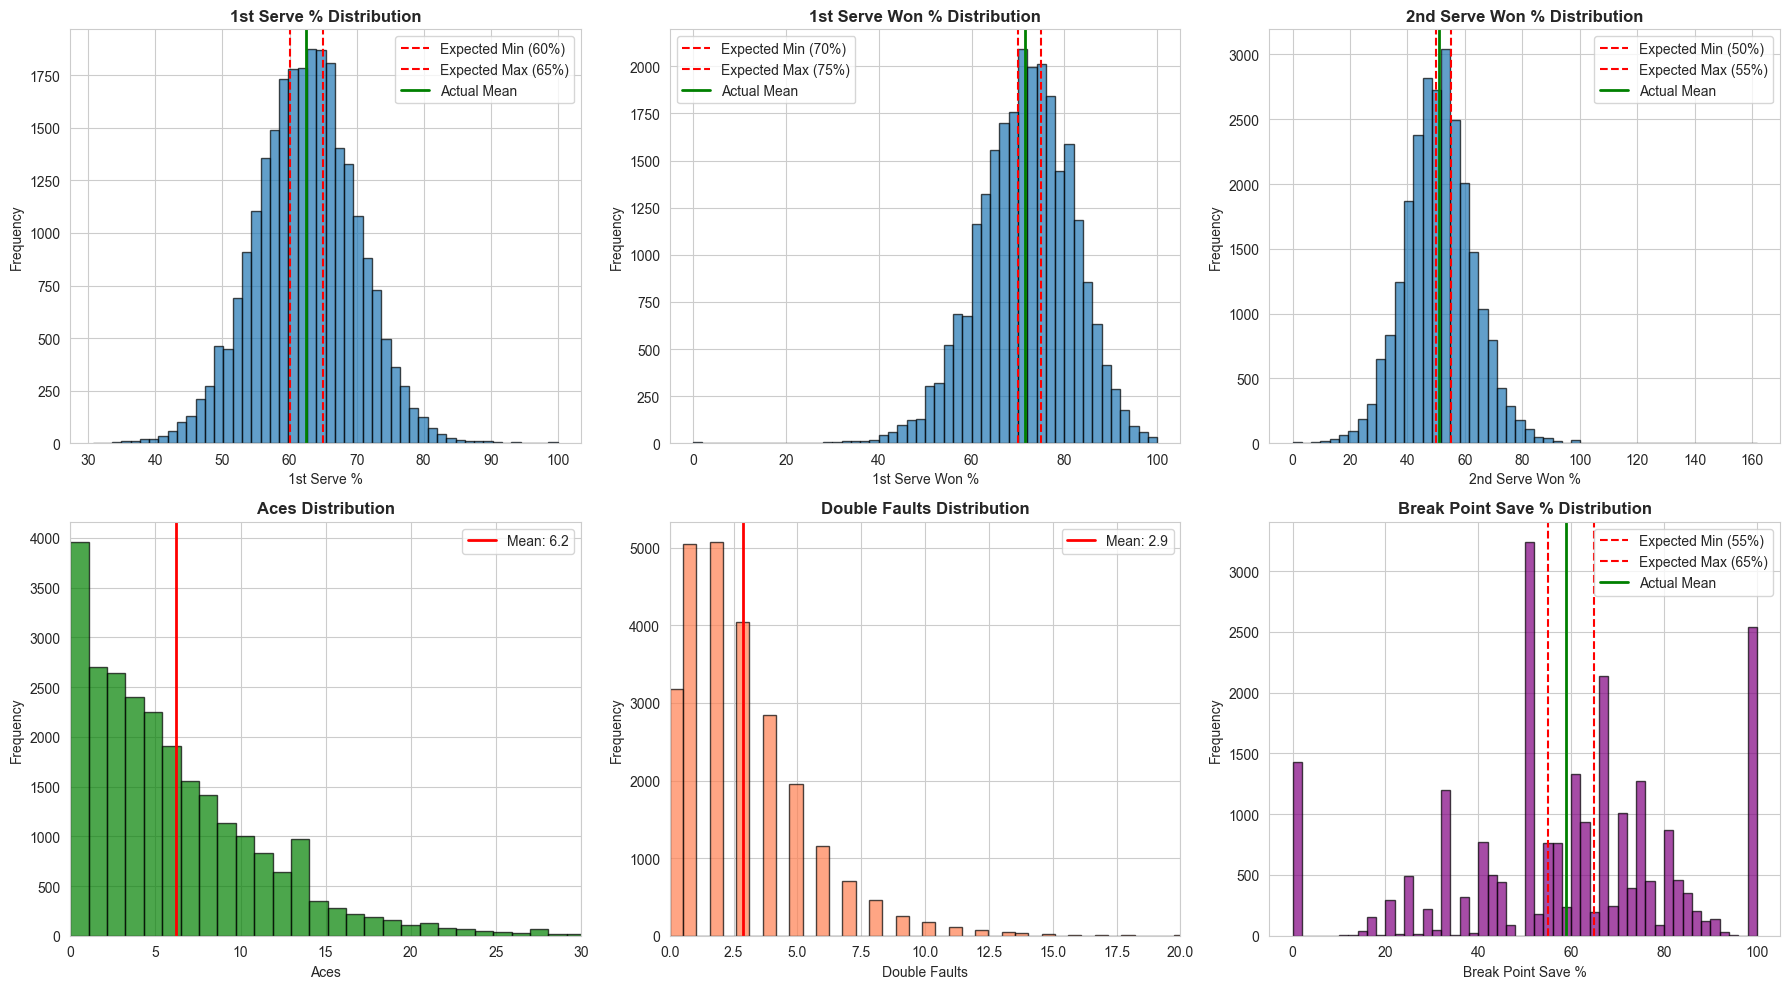

✅ Statistical distributions saved: statistical_distributions.png


In [7]:
# Visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1st Serve %
axes[0, 0].hist(stats_valid['first_serve_pct']*100, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(60, color='r', linestyle='--', label='Expected Min (60%)')
axes[0, 0].axvline(65, color='r', linestyle='--', label='Expected Max (65%)')
axes[0, 0].axvline(stats_valid['first_serve_pct'].mean()*100, color='green', linestyle='-', linewidth=2, label='Actual Mean')
axes[0, 0].set_xlabel('1st Serve %')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('1st Serve % Distribution', fontweight='bold')
axes[0, 0].legend()

# 1st Serve Won %
axes[0, 1].hist(stats_valid['first_serve_win_pct']*100, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(70, color='r', linestyle='--', label='Expected Min (70%)')
axes[0, 1].axvline(75, color='r', linestyle='--', label='Expected Max (75%)')
axes[0, 1].axvline(stats_valid['first_serve_win_pct'].mean()*100, color='green', linestyle='-', linewidth=2, label='Actual Mean')
axes[0, 1].set_xlabel('1st Serve Won %')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('1st Serve Won % Distribution', fontweight='bold')
axes[0, 1].legend()

# 2nd Serve Won %
axes[0, 2].hist(stats_valid['second_serve_win_pct']*100, bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].axvline(50, color='r', linestyle='--', label='Expected Min (50%)')
axes[0, 2].axvline(55, color='r', linestyle='--', label='Expected Max (55%)')
axes[0, 2].axvline(stats_valid['second_serve_win_pct'].mean()*100, color='green', linestyle='-', linewidth=2, label='Actual Mean')
axes[0, 2].set_xlabel('2nd Serve Won %')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('2nd Serve Won % Distribution', fontweight='bold')
axes[0, 2].legend()

# Aces
axes[1, 0].hist(stats_valid['aces'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].axvline(stats_valid['aces'].mean(), color='red', linestyle='-', linewidth=2, label=f'Mean: {stats_valid["aces"].mean():.1f}')
axes[1, 0].set_xlabel('Aces')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Aces Distribution', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 30)

# Double Faults
axes[1, 1].hist(stats_valid['double_faults'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].axvline(stats_valid['double_faults'].mean(), color='red', linestyle='-', linewidth=2, label=f'Mean: {stats_valid["double_faults"].mean():.1f}')
axes[1, 1].set_xlabel('Double Faults')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Double Faults Distribution', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 20)

# Break Point Save %
axes[1, 2].hist(stats_valid['break_point_save_pct'].dropna()*100, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 2].axvline(55, color='r', linestyle='--', label='Expected Min (55%)')
axes[1, 2].axvline(65, color='r', linestyle='--', label='Expected Max (65%)')
axes[1, 2].axvline(stats_valid['break_point_save_pct'].mean()*100, color='green', linestyle='-', linewidth=2, label='Actual Mean')
axes[1, 2].set_xlabel('Break Point Save %')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Break Point Save % Distribution', fontweight='bold')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig('statistical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Statistical distributions saved: statistical_distributions.png")

## 4. Surface Distribution

4. SURFACE DISTRIBUTION

🎾 Surface Distribution:

   Hard      : 7,884 matches ( 59.9%)
   Clay      : 3,940 matches ( 29.9%)
   Grass     : 1,289 matches (  9.8%)

📊 Validation against expected ranges:
✅ Hard: 59.9% (expected: 55-65%)
✅ Clay: 29.9% (expected: 20-35%)
✅ Grass: 9.8% (expected: 5-15%)


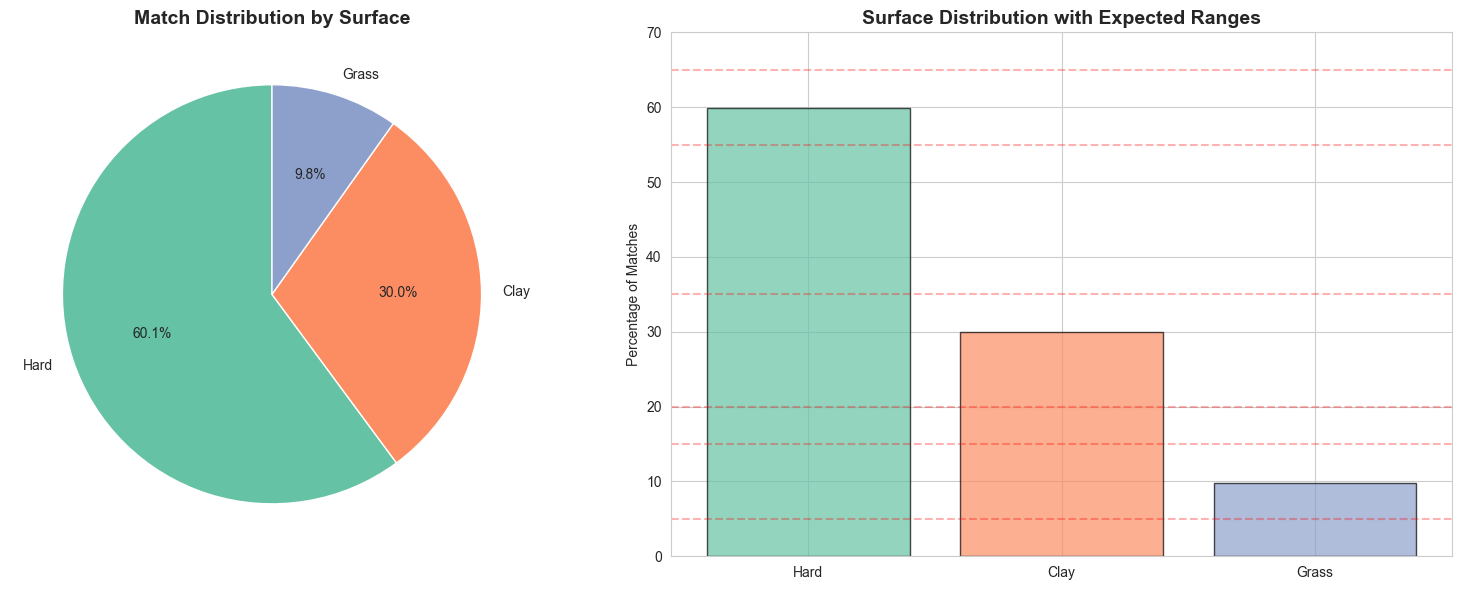


✅ Surface distribution saved: surface_distribution.png


In [8]:
print("="*80)
print("4. SURFACE DISTRIBUTION")
print("="*80)

surface_counts = matches_df['surface'].value_counts()
surface_pct = (surface_counts / len(matches_df)) * 100

print("\n🎾 Surface Distribution:\n")
for surface, count in surface_counts.items():
    pct = (count / len(matches_df)) * 100
    print(f"   {surface:<10}: {count:>5,} matches ({pct:>5.1f}%)")

# Expected ranges
expected_ranges = {
    'Hard': (55, 65),
    'Clay': (20, 35),
    'Grass': (5, 15)
}

print("\n📊 Validation against expected ranges:")
for surface, (min_exp, max_exp) in expected_ranges.items():
    if surface in surface_pct:
        actual = surface_pct[surface]
        status = "✅" if min_exp <= actual <= max_exp else "⚠️"
        print(f"{status} {surface}: {actual:.1f}% (expected: {min_exp}-{max_exp}%)")

# Pie chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
colors = sns.color_palette('Set2', len(surface_counts))
axes[0].pie(surface_counts.values, labels=surface_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colors)
axes[0].set_title('Match Distribution by Surface', fontsize=14, fontweight='bold')

# Bar chart with expected ranges
x_pos = range(len(surface_counts))
axes[1].bar(x_pos, surface_pct.values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(surface_counts.index)
axes[1].set_ylabel('Percentage of Matches')
axes[1].set_title('Surface Distribution with Expected Ranges', fontsize=14, fontweight='bold')

# Add expected range bands
for i, surface in enumerate(surface_counts.index):
    if surface in expected_ranges:
        min_exp, max_exp = expected_ranges[surface]
        axes[1].axhline(y=min_exp, color='red', linestyle='--', alpha=0.3)
        axes[1].axhline(y=max_exp, color='red', linestyle='--', alpha=0.3)

axes[1].set_ylim(0, 70)

plt.tight_layout()
plt.savefig('surface_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Surface distribution saved: surface_distribution.png")

## 5. Temporal Coverage

5. TEMPORAL COVERAGE

📅 Date Range: 2020-01-06 to 2024-12-18
   Total months covered: 53
   Average matches per month: 248
   Min matches in a month: 10 (2021-12)
   Max matches in a month: 455 (2024-02)

⚠️  Months with <50 matches: 3
   These months may have data gaps:
     2021-12: 10 matches
     2022-11: 44 matches
     2024-12: 15 matches


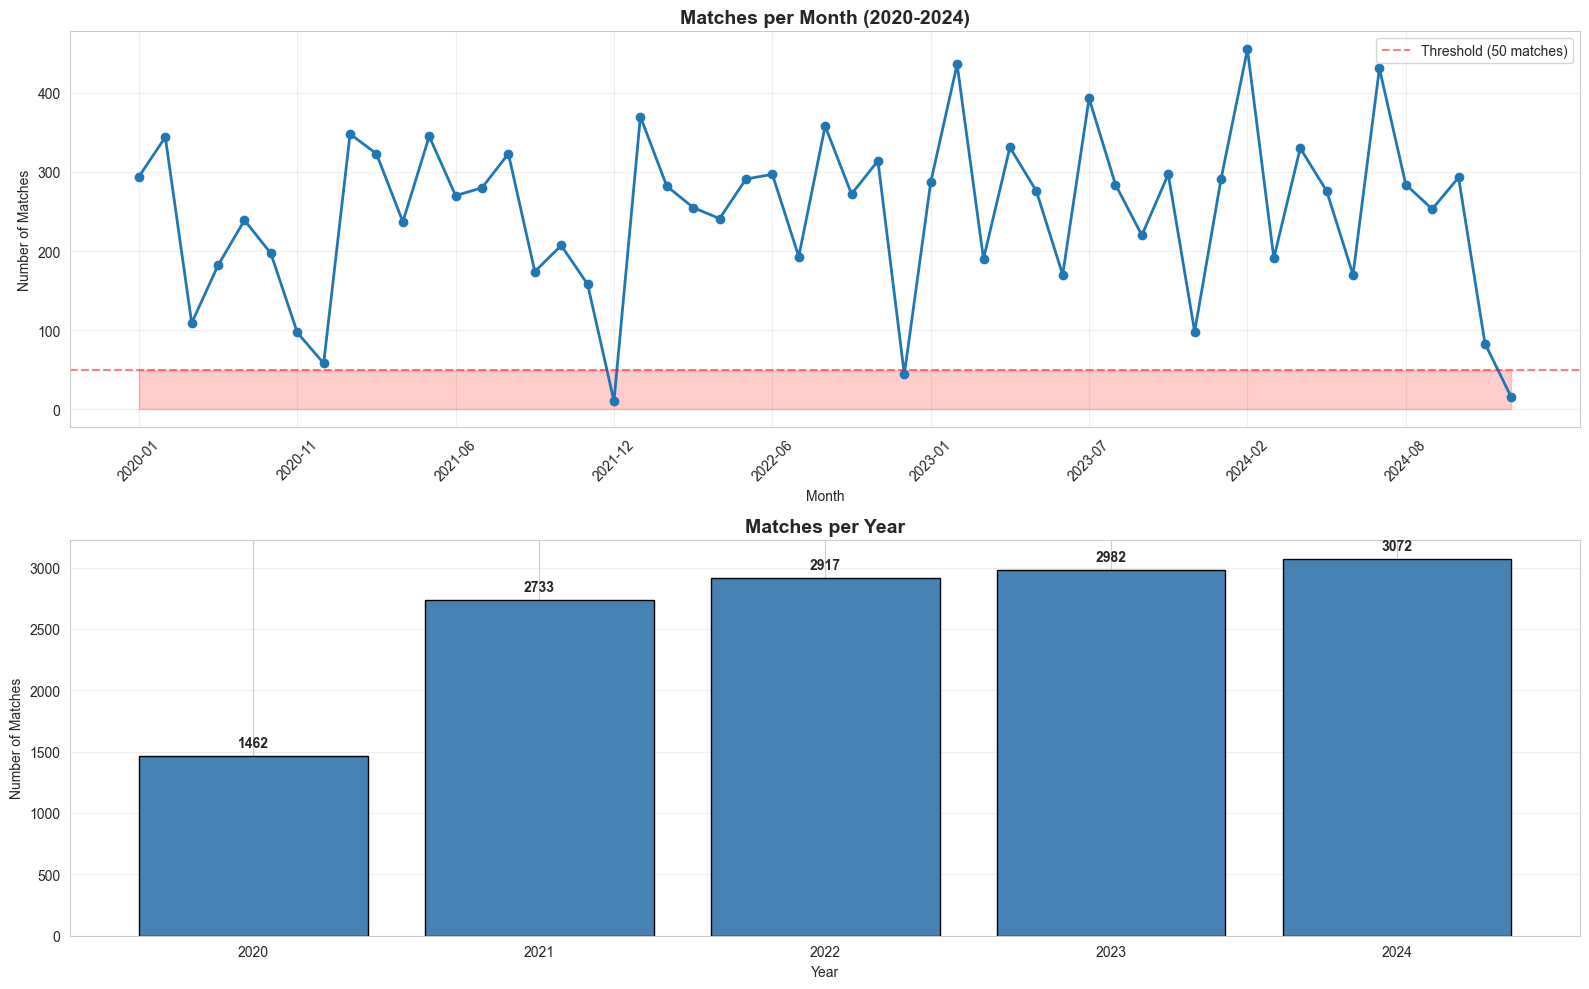


✅ Temporal coverage saved: temporal_coverage.png


In [9]:
print("="*80)
print("5. TEMPORAL COVERAGE")
print("="*80)

# Matches per month
matches_df['year_month'] = matches_df['tournament_date'].dt.to_period('M')
matches_per_month = matches_df.groupby('year_month').size()

print(f"\n📅 Date Range: {matches_df['tournament_date'].min().strftime('%Y-%m-%d')} to {matches_df['tournament_date'].max().strftime('%Y-%m-%d')}")
print(f"   Total months covered: {len(matches_per_month)}")
print(f"   Average matches per month: {matches_per_month.mean():.0f}")
print(f"   Min matches in a month: {matches_per_month.min()} ({matches_per_month.idxmin()})")
print(f"   Max matches in a month: {matches_per_month.max()} ({matches_per_month.idxmax()})")

# Flag months with low coverage
low_coverage_months = matches_per_month[matches_per_month < 50]
if len(low_coverage_months) > 0:
    print(f"\n⚠️  Months with <50 matches: {len(low_coverage_months)}")
    print("   These months may have data gaps:")
    for month, count in low_coverage_months.items():
        print(f"     {month}: {count} matches")
    
    issues.append({
        'check': 'Temporal Coverage',
        'issue': f'{len(low_coverage_months)} months with fewer than 50 matches',
        'severity': 'WARNING',
        'count': len(low_coverage_months)
    })
else:
    print(f"\n✅ All months have adequate coverage (≥50 matches)")

# Plot matches over time
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Matches per month
axes[0].plot(matches_per_month.index.astype(str), matches_per_month.values, marker='o', linewidth=2)
axes[0].axhline(y=50, color='r', linestyle='--', label='Threshold (50 matches)', alpha=0.5)
axes[0].fill_between(range(len(matches_per_month)), 0, 50, alpha=0.2, color='red')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Matches')
axes[0].set_title('Matches per Month (2020-2024)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)
# Only show every 6th month label
tick_positions = range(0, len(matches_per_month), 6)
axes[0].set_xticks(tick_positions)
axes[0].set_xticklabels([matches_per_month.index.astype(str)[i] for i in tick_positions])

# Matches per year
matches_df['year'] = matches_df['tournament_date'].dt.year
matches_per_year = matches_df.groupby('year').size()
axes[1].bar(matches_per_year.index, matches_per_year.values, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Matches')
axes[1].set_title('Matches per Year', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (year, count) in enumerate(matches_per_year.items()):
    axes[1].text(year, count + 50, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('temporal_coverage.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Temporal coverage saved: temporal_coverage.png")

## 6. Data Quality Summary & Export

In [10]:
print("="*80)
print("6. DATA QUALITY SUMMARY")
print("="*80)

# Create issues DataFrame
if len(issues) > 0:
    issues_df = pd.DataFrame(issues)
    
    print(f"\n⚠️  Total issues found: {len(issues_df)}\n")
    
    # Group by severity
    print("Issues by severity:")
    severity_counts = issues_df['severity'].value_counts()
    for severity, count in severity_counts.items():
        icon = "🔴" if severity == "ERROR" else "⚠️" if severity == "WARNING" else "ℹ️"
        print(f"   {icon} {severity}: {count}")
    
    print(f"\n📋 Detailed issues:")
    for idx, issue in issues_df.iterrows():
        print(f"   [{issue['severity']}] {issue['check']}: {issue['issue']}")
    
    # Save issues to CSV
    issues_df.to_csv('issues.csv', index=False)
    print(f"\n✅ Issues exported to: issues.csv")
else:
    print(f"\n✅ No issues found! Data quality is excellent.")
    issues_df = pd.DataFrame(columns=['check', 'issue', 'severity', 'count'])
    issues_df.to_csv('issues.csv', index=False)
    print(f"✅ Empty issues file created: issues.csv")

6. DATA QUALITY SUMMARY

⚠️  Total issues found: 4

Issues by severity:
   ⚠️ WARNING: 2
   ℹ️ INFO: 1
   🔴 ERROR: 1

📋 Detailed issues:
   [INFO] Completeness: 500 players have fewer than 10 matches
   [ERROR] Range Validation: second_serve_win_pct has 1 values outside [0, 1]
   [WARNING] Range Validation: 68 matches with >30 aces (suspicious)
   [WARNING] Temporal Coverage: 3 months with fewer than 50 matches

✅ Issues exported to: issues.csv


In [11]:
# Generate comprehensive HTML report
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>ATP Tennis Data Quality Report</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; background-color: #f5f5f5; }}
        h1 {{ color: #2c3e50; border-bottom: 3px solid #3498db; padding-bottom: 10px; }}
        h2 {{ color: #34495e; margin-top: 30px; border-bottom: 2px solid #95a5a6; padding-bottom: 5px; }}
        .summary {{ background: white; padding: 20px; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1); margin: 20px 0; }}
        .stat {{ display: inline-block; margin: 10px 20px; }}
        .stat-label {{ font-weight: bold; color: #7f8c8d; }}
        .stat-value {{ font-size: 24px; color: #2c3e50; font-weight: bold; }}
        .success {{ color: #27ae60; }}
        .warning {{ color: #f39c12; }}
        .error {{ color: #e74c3c; }}
        img {{ max-width: 100%; height: auto; margin: 20px 0; border: 1px solid #ddd; border-radius: 4px; }}
        table {{ border-collapse: collapse; width: 100%; margin: 20px 0; background: white; }}
        th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
        th {{ background-color: #3498db; color: white; }}
        tr:nth-child(even) {{ background-color: #f9f9f9; }}
        .metric {{ background: white; padding: 15px; margin: 10px 0; border-left: 4px solid #3498db; }}
    </style>
</head>
<body>
    <h1>🎾 ATP Tennis Data Quality Validation Report</h1>
    
    <div class="summary">
        <h2>Executive Summary</h2>
        <div class="stat">
            <div class="stat-label">Total Matches</div>
            <div class="stat-value">{len(matches_df):,}</div>
        </div>
        <div class="stat">
            <div class="stat-label">Statistics Coverage</div>
            <div class="stat-value success">{stats_coverage:.1f}%</div>
        </div>
        <div class="stat">
            <div class="stat-label">Total Players</div>
            <div class="stat-value">{len(players_df):,}</div>
        </div>
        <div class="stat">
            <div class="stat-label">Issues Found</div>
            <div class="stat-value {'success' if len(issues_df) == 0 else 'warning'}">{len(issues_df)}</div>
        </div>
    </div>
    
    <h2>1. Completeness Checks</h2>
    <div class="metric">
        <strong>✅ Matches with complete statistics:</strong> {matches_with_stats:,} ({stats_coverage:.1f}%)<br>
        <strong>✅ Statistics records with data:</strong> {len(stats_with_aces):,} ({aces_coverage:.1f}%)<br>
        <strong>⚠️ Players with &lt;10 matches:</strong> {players_few_matches} ({players_few_matches/len(players_df)*100:.1f}%)
    </div>
    <img src="missing_values_heatmap.png" alt="Missing Values Heatmap">
    
    <h2>2. Statistical Sanity Checks</h2>
    <div class="metric">
        <strong>Average 1st Serve %:</strong> {stats_valid['first_serve_pct'].mean()*100:.1f}% (expected: 60-65%)<br>
        <strong>Average 1st Serve Won %:</strong> {stats_valid['first_serve_win_pct'].mean()*100:.1f}% (expected: 70-75%)<br>
        <strong>Average 2nd Serve Won %:</strong> {stats_valid['second_serve_win_pct'].mean()*100:.1f}% (expected: 50-55%)<br>
        <strong>Average Aces:</strong> {stats_valid['aces'].mean():.2f}<br>
        <strong>Average Double Faults:</strong> {stats_valid['double_faults'].mean():.2f}
    </div>
    <img src="statistical_distributions.png" alt="Statistical Distributions">
    
    <h2>3. Surface Distribution</h2>
    <img src="surface_distribution.png" alt="Surface Distribution">
    
    <h2>4. Temporal Coverage</h2>
    <div class="metric">
        <strong>Date Range:</strong> {matches_df['tournament_date'].min().strftime('%Y-%m-%d')} to {matches_df['tournament_date'].max().strftime('%Y-%m-%d')}<br>
        <strong>Average matches per month:</strong> {matches_per_month.mean():.0f}<br>
        <strong>Months with low coverage (&lt;50):</strong> {len(low_coverage_months)}
    </div>
    <img src="temporal_coverage.png" alt="Temporal Coverage">
    
    <h2>5. Issues Identified</h2>
    {'<p class="success"><strong>✅ No issues found! Data quality is excellent.</strong></p>' if len(issues_df) == 0 else issues_df.to_html(index=False, classes='issues-table')}
    
    <div class="summary">
        <h2>Conclusion</h2>
        <p><strong>Overall Assessment:</strong> {'✅ EXCELLENT - Data is ready for model building' if len(issues_df) <= 3 else '⚠️ GOOD - Minor issues identified, review recommended' if len(issues_df) <= 10 else '🔴 NEEDS ATTENTION - Multiple issues require review'}</p>
        <p><strong>Recommendation:</strong> {'Proceed with model building' if len(issues_df) <= 3 else 'Review issues.csv before proceeding'}</p>
        <p><strong>Report Generated:</strong> {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
    </div>
</body>
</html>
"""

# Save HTML report
with open('data_quality_report.html', 'w') as f:
    f.write(html_content)

print("\n✅ HTML report generated: data_quality_report.html")
print("   Open this file in a web browser to view the complete report with visualizations")


✅ HTML report generated: data_quality_report.html
   Open this file in a web browser to view the complete report with visualizations


In [12]:
# Final summary
print("\n" + "="*80)
print("VALIDATION COMPLETE")
print("="*80)

print(f"\n📊 SUMMARY:")
print(f"   Total Matches: {len(matches_df):,}")
print(f"   Statistics Coverage: {stats_coverage:.1f}%")
print(f"   Total Players: {len(players_df):,}")
print(f"   Issues Found: {len(issues_df)}")

if len(issues_df) > 0:
    print(f"\n⚠️  ACTION REQUIRED:")
    print(f"   1. Review issues.csv for details")
    print(f"   2. Open data_quality_report.html in browser")
    print(f"   3. Decide: proceed with current data or clean issues first")
else:
    print(f"\n✅ DATA QUALITY: EXCELLENT")
    print(f"   No issues found. Safe to proceed with model building.")

print(f"\n📁 FILES GENERATED:")
print(f"   ✅ data_quality_report.html - Comprehensive report with visualizations")
print(f"   ✅ issues.csv - Detailed list of issues (if any)")
print(f"   ✅ missing_values_heatmap.png")
print(f"   ✅ statistical_distributions.png")
print(f"   ✅ surface_distribution.png")
print(f"   ✅ temporal_coverage.png")

print(f"\n" + "="*80)
print(f"Validation completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)


VALIDATION COMPLETE

📊 SUMMARY:
   Total Matches: 13,166
   Statistics Coverage: 95.9%
   Total Players: 780
   Issues Found: 4

⚠️  ACTION REQUIRED:
   1. Review issues.csv for details
   2. Open data_quality_report.html in browser
   3. Decide: proceed with current data or clean issues first

📁 FILES GENERATED:
   ✅ data_quality_report.html - Comprehensive report with visualizations
   ✅ issues.csv - Detailed list of issues (if any)
   ✅ missing_values_heatmap.png
   ✅ statistical_distributions.png
   ✅ surface_distribution.png
   ✅ temporal_coverage.png

Validation completed at: 2025-12-27 21:01:46


In [ ]:
# Close database connection
conn.close()
print("\n✅ Database connection closed")